# Setup 

In [1]:
%matplotlib inline

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.autograd import Variable
from torchvision import datasets, transforms

# Dataloaders

In [498]:
transform = transforms.Compose([
                       transforms.ToTensor(), #normalise to range -1 to 1
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [499]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

# ModelBuilders + plot funcs

## Nets 

In [11]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [12]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
def rebuild_from_save(df, generation, position):
    
    genome = df[df['Generation'] == generation].iloc[position, -2]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

In [ ]:
def test(model, test_loader):
    
    model.train(False)
    
    scores = defaultdict(int)
    classes = defaultdict(int)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred))
            for i in range(10):
                mask = target==i
                classes[i] += mask.sum().item()
                scores[i] += correct[mask].sum().item()
    
    return (scores, classes)

## Plotters

In [309]:
def importances(label, model):
    pixel_importances = []
    
    params = list(model.parameters())
    
    layer_one = params[0].detach().cpu().numpy()
    biases_one = params[1].detach().cpu().numpy()
    layer_two = params[2].detach().cpu().numpy()
    biases_two = params[3].detach().cpu().numpy()
    
    for i in range(784):
        first_layer = layer_one[:, i] + biases_one
        second_layer = first_layer * layer_two[label:, ] + biases_two[label]
        pixel_importances.append(second_layer.sum())
    pixel_importances = np.array(pixel_importances).reshape(28,28)
    return pixel_importances

In [349]:
def importances_plotter(model, normalise = False, hists=False): 
    fig = plt.figure(figsize=(20,20))
    for i in range(10):
        ax = fig.add_subplot(4,3, i+1)
        im = importances(i, model)
        if normalise:
            im = (im - im.min()) / (im.max() - im.min())
        if hists:
            ax.hist(im.flatten())
        else:
            immer = ax.imshow(im, cmap='Reds')
            plt.colorbar(immer, ax=ax)
            ax.text(x=8, y=32, s="Label: {}".format(i), fontsize=20)

In [ ]:
def most_important_plot(model): 
    most_ims = []
    fig = plt.figure(figsize=(20,20))
    for i in range(10):
        ax = fig.add_subplot(4,3, i+1)
        im = importances(i, model).flatten()
        mask = np.where(im == im.max(), 1,0)
        most_ims.append(np.argmax(im))
        im = im[mask].reshape(28,28)
        immer = ax.imshow(im, cmap='Reds')
        plt.colorbar(immer, ax=ax)
        ax.text(x=8, y=32, s="Label: {}".format(i), fontsize=20)
    return most_ims

# Exploration

In [5]:
df = pd.read_pickle(r"../data/neuroevolution2")

In [30]:
popnums = [j for i in range(100) for j in range(30)]

In [31]:
df['popnum'] = popnums

In [33]:
df[df['Adversarial'] == df['Adversarial'].max()]

,Generation,Clean,Adversarial,No_layers,Lr,Act_func,Nb_units,Dropout,Genome,popnum
2032,68,9112,8577,1,0.078663,linear,1577,0.673602,"{'optimizer': 'rmsprop', 'weight_decay': 4.712...",22


In [78]:
df[df['Adversarial'] == df['Adversarial'].max()].iloc[0,-2]

{'layers': [{'activation': 'linear',
   'dropout_rate': 0.6736020681051939,
   'nb_units': 1577}],
 'lr': 0.07866303147789494,
 'nb_layers': 1,
 'optimizer': 'rmsprop',
 'weight_decay': 4.712941984142251e-05}

In [321]:
model = rebuild_from_save(df, 68, 22)

In [322]:
model

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1577, bias=True)
    (dropout_0): Dropout(p=0.6736020681051939)
    (logits): Linear(in_features=1577, out_features=10, bias=True)
  )
)

In [47]:
count_parameters(model)

1253725

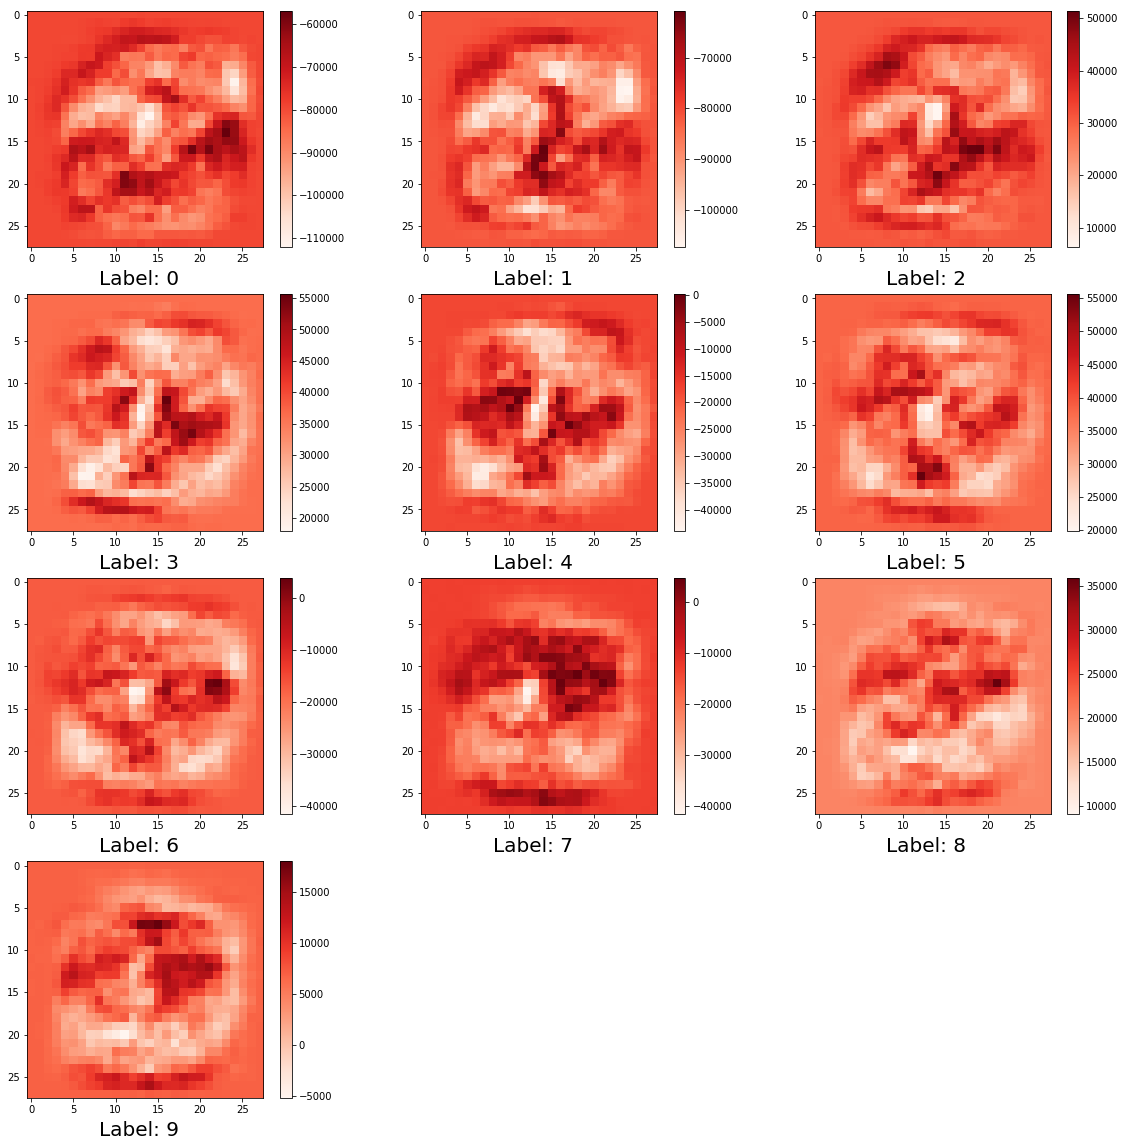

In [339]:
importances_plotter(model)

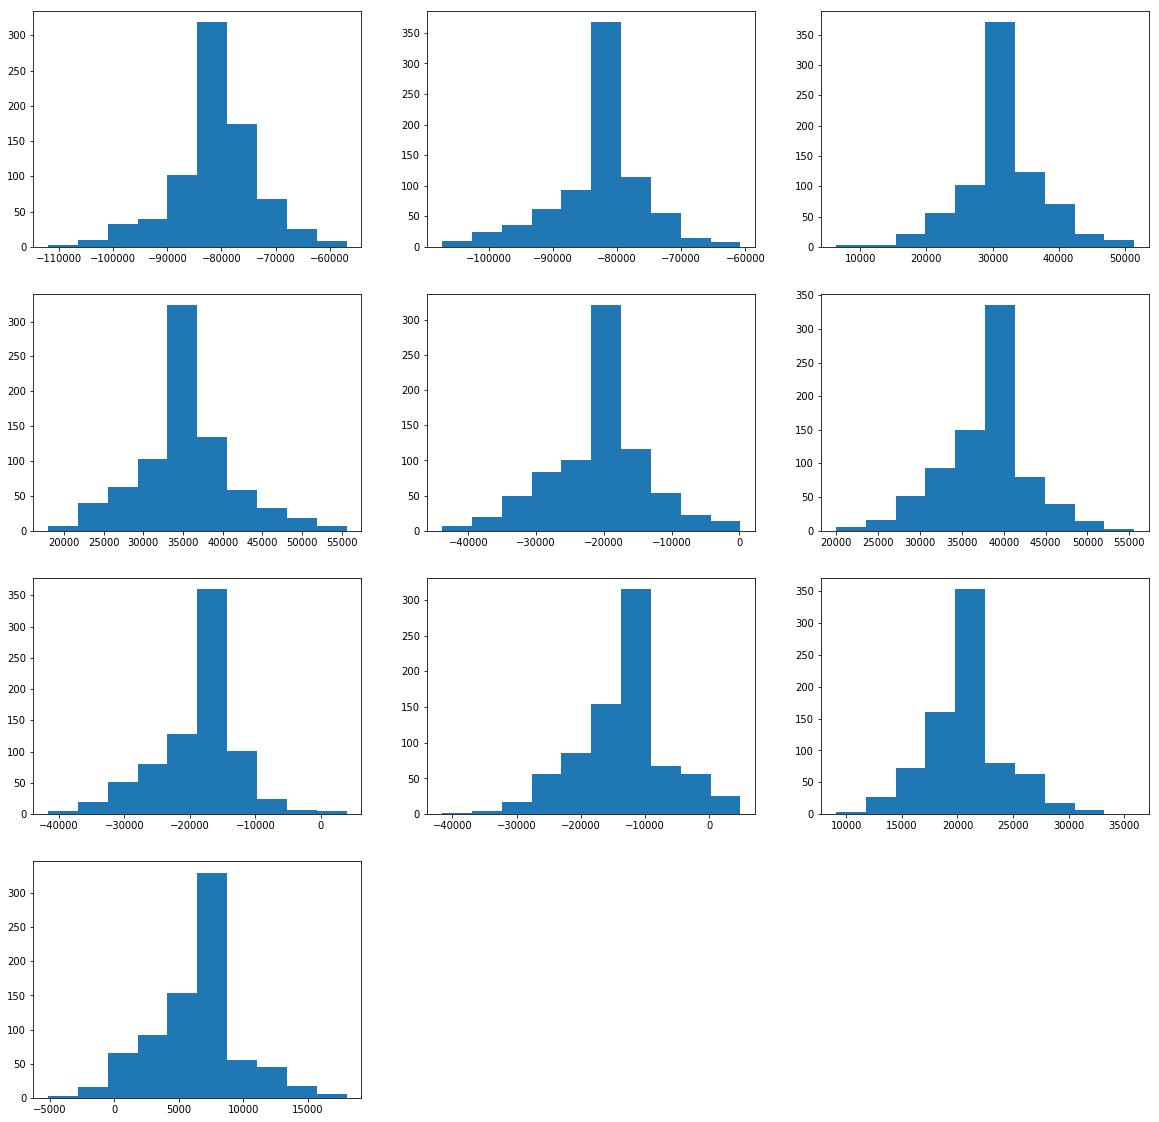

In [350]:
importances_plotter(model, hists=True)

In [280]:
model2= model = rebuild_from_save(df, 40, 25)

In [281]:
model2

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1374, bias=True)
    (dropout_0): Dropout(p=0.5509994795571279)
    (logits): Linear(in_features=1374, out_features=10, bias=True)
  )
)

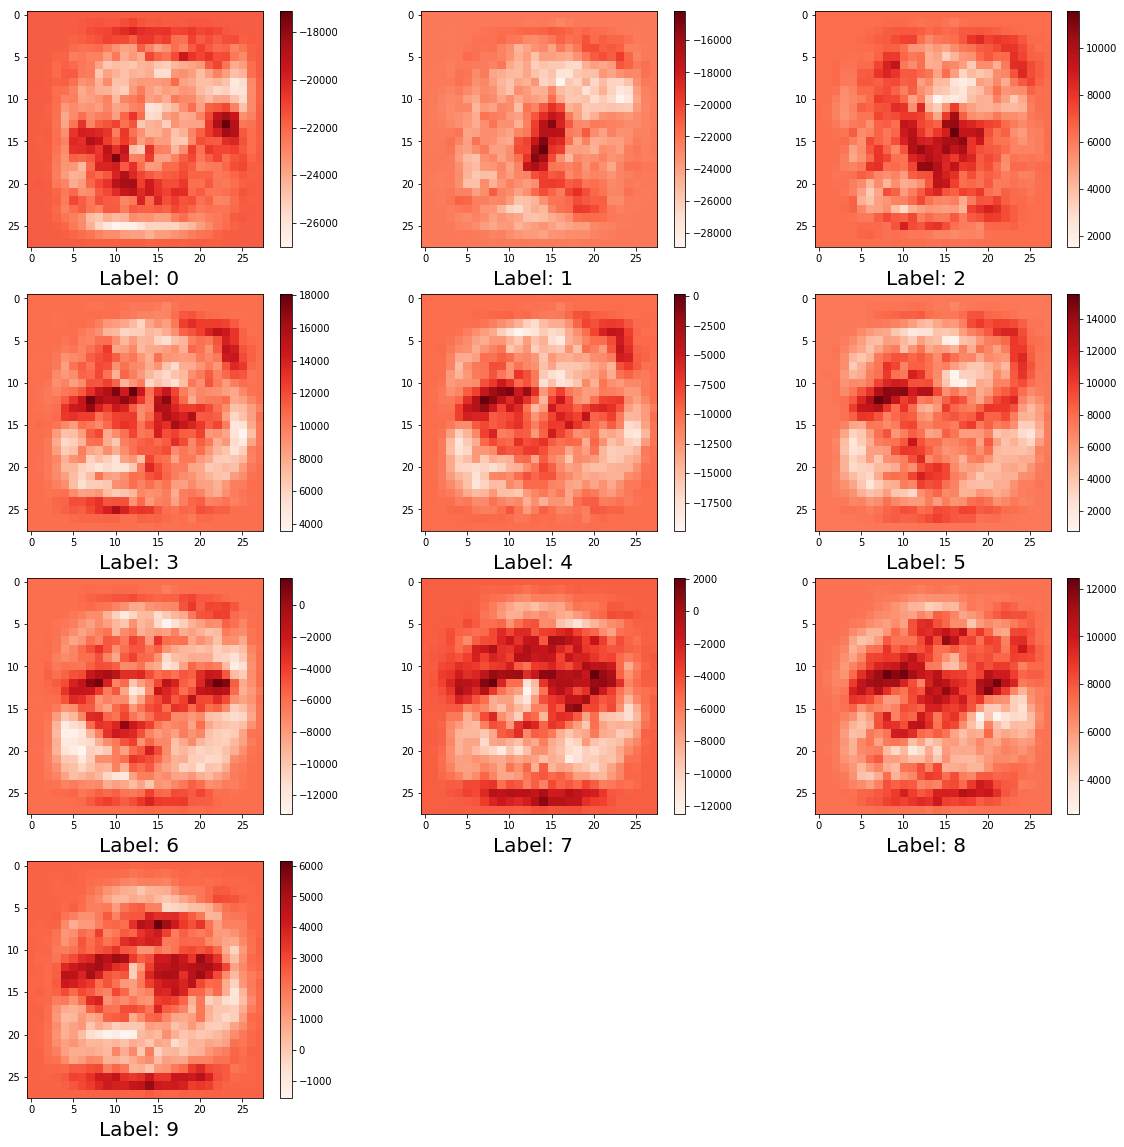

In [312]:
importances_plotter(model2)

In [323]:
model

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1577, bias=True)
    (dropout_0): Dropout(p=0.6736020681051939)
    (logits): Linear(in_features=1577, out_features=10, bias=True)
  )
)

In [324]:
model2

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1374, bias=True)
    (dropout_0): Dropout(p=0.5509994795571279)
    (logits): Linear(in_features=1374, out_features=10, bias=True)
  )
)

In [467]:
def per_class_plot(model, test_loader):
    corrects, totals = test(model, test_loader)
    df = pd.DataFrame([corrects, totals]).T
    df['pct'] = df[0] / df[1]
    df['pct'].plot(kind='barh', color='Blue');

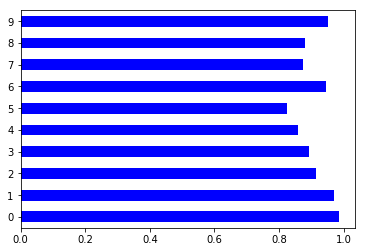

In [468]:
per_class_plot(model, test_loader)

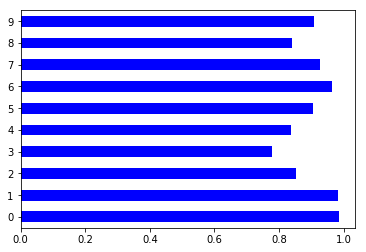

In [469]:
per_class_plot(model2, test_loader)

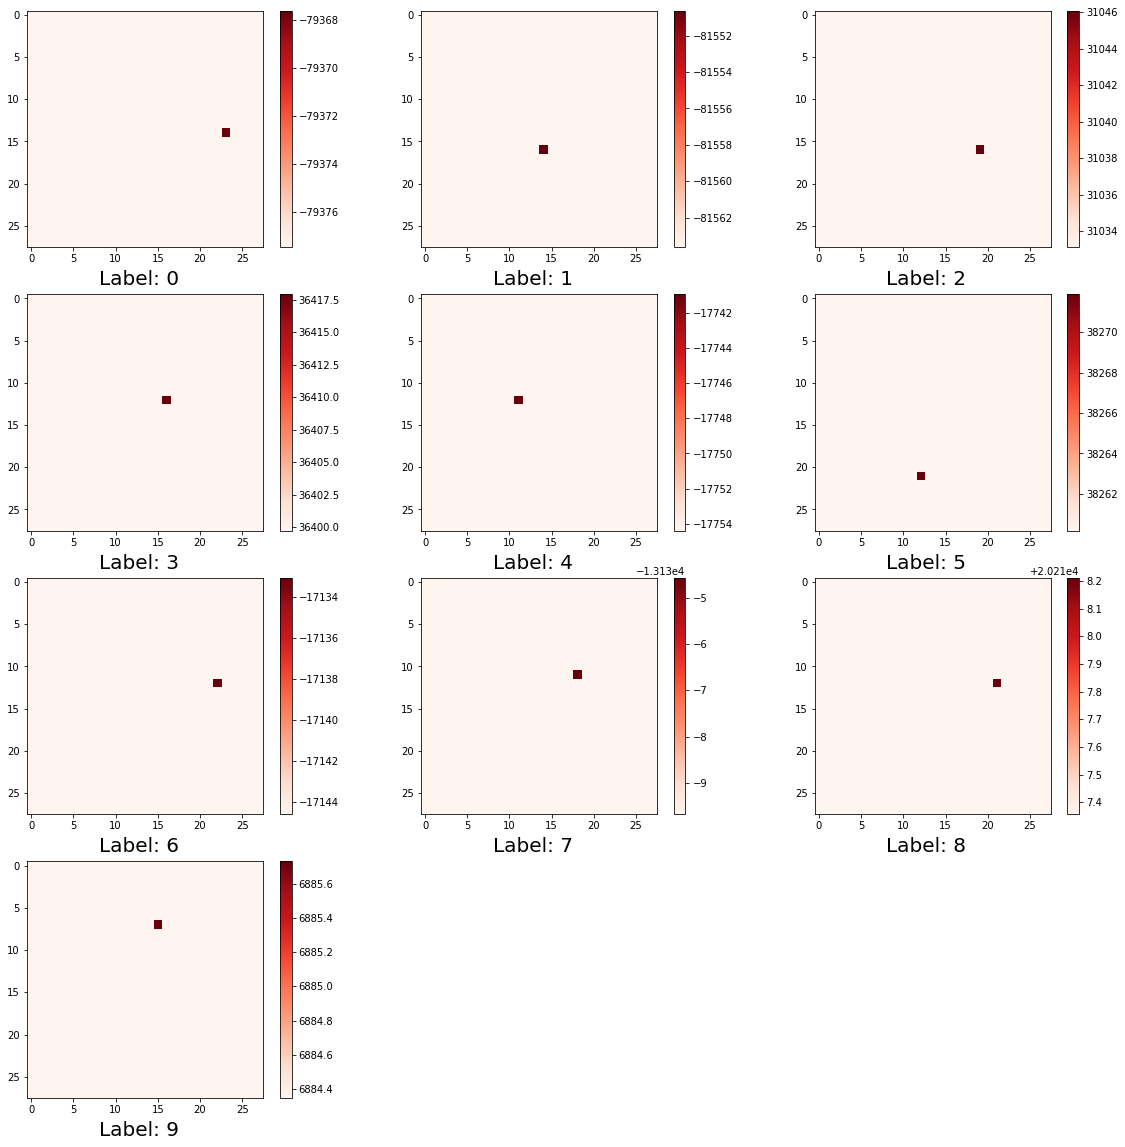

In [484]:
most_ims = most_important_plot(model)

In [485]:
most_ims

[415, 462, 467, 352, 347, 600, 358, 326, 357, 211]

In [533]:
def avg_img(test_loader):

    classes = defaultdict(int)
    avgs = defaultdict(int)

    for data, target in test_loader:
        data = data.numpy()
        for j, im in enumerate(data):
            avgs[target[j].item()] += im
            classes[target[j].item()] += 1

    return {i: avgs[i] / classes[i] for i in classes}

In [534]:
findict = avg_img(train_loader)

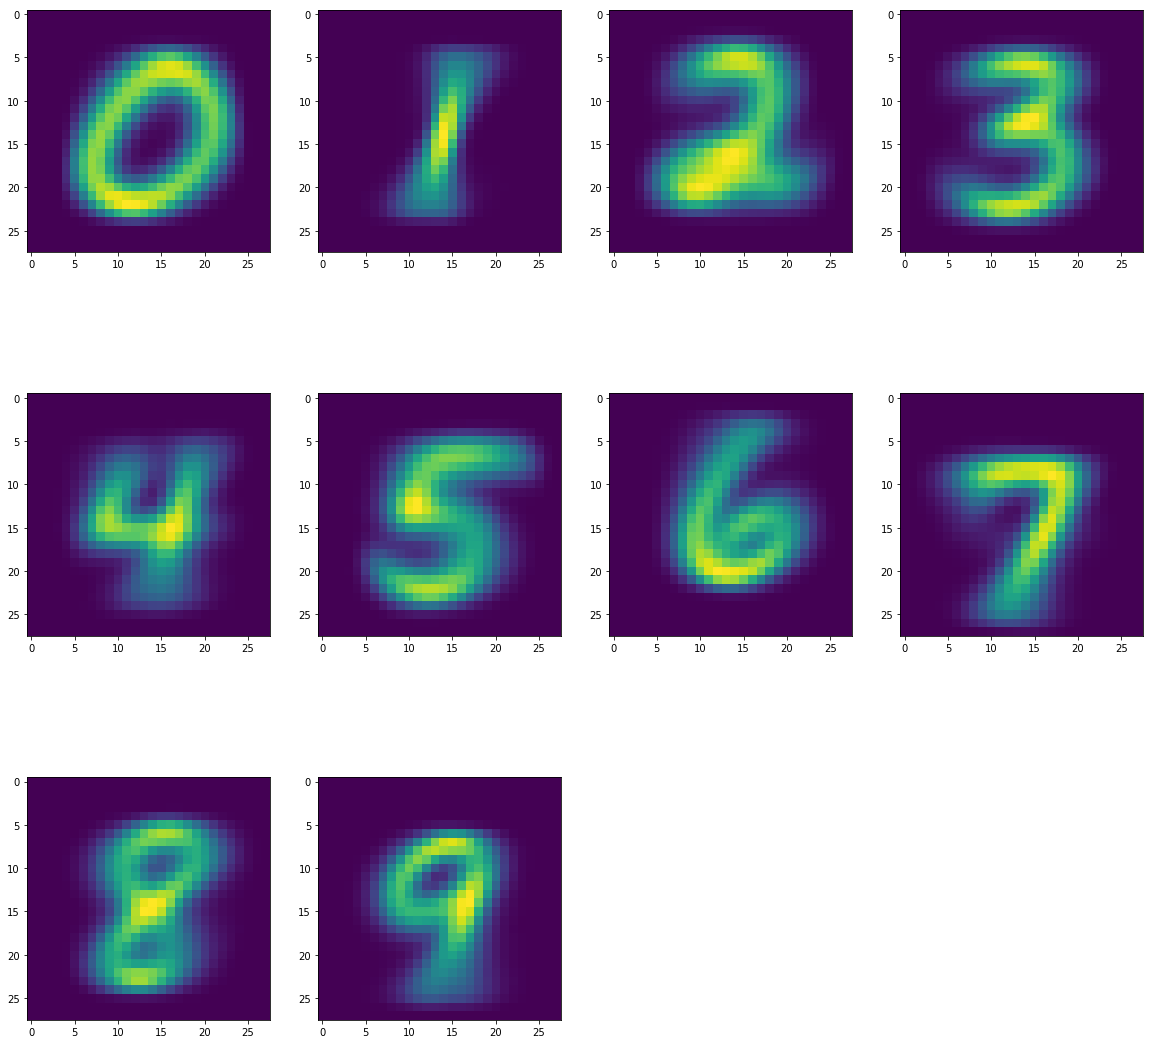

In [565]:
fig = plt.figure(figsize=(20,20))
for i in range(10):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(findict[i].reshape(28,28))

In [562]:
def standouts(findict, digit):
    de = defaultdict(int)
    for im in findict:
        if im == digit:
            continue
        de['_'] += findict[im]
    de['_'] /= 9
    de['_'] = findict[digit] - de['_']
    return de['_'].reshape(28,28)

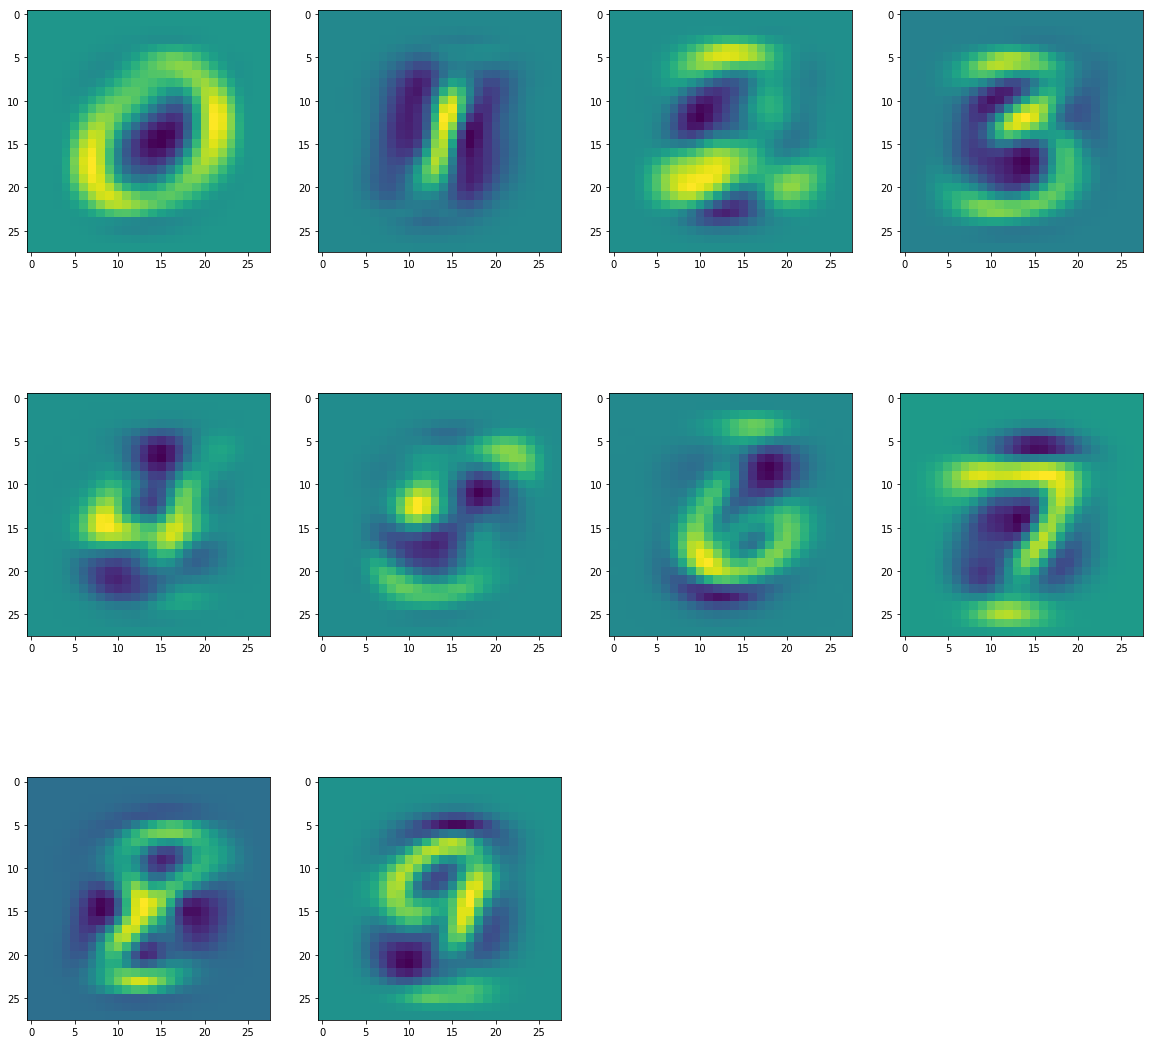

In [567]:
fig = plt.figure(figsize=(20,20))
for i in range(10):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(standouts(findict, i))

In [629]:
np.sort([8,2,7])[::-1]

array([8, 7, 2])

In [648]:
def focus(model, pixels):
    fig = plt.figure(figsize=(30,20))
    for i in range(10):
        ax = fig.add_subplot(3,4, i+1)
        im = importances(i, model).flatten()
        most_ims = np.argsort(im)[::-1][:pixels]
        im = standouts(findict, i)

        cmap = plt.cm.gray
        norm = plt.Normalize(im.min(), im.max())
        rgba = cmap(norm(im))
        for j in most_ims:
            w = j % 28 
            h = int(j / 28)
            rgba[h, w, :3] = 1, 0, 0
            
        ax.imshow(rgba)

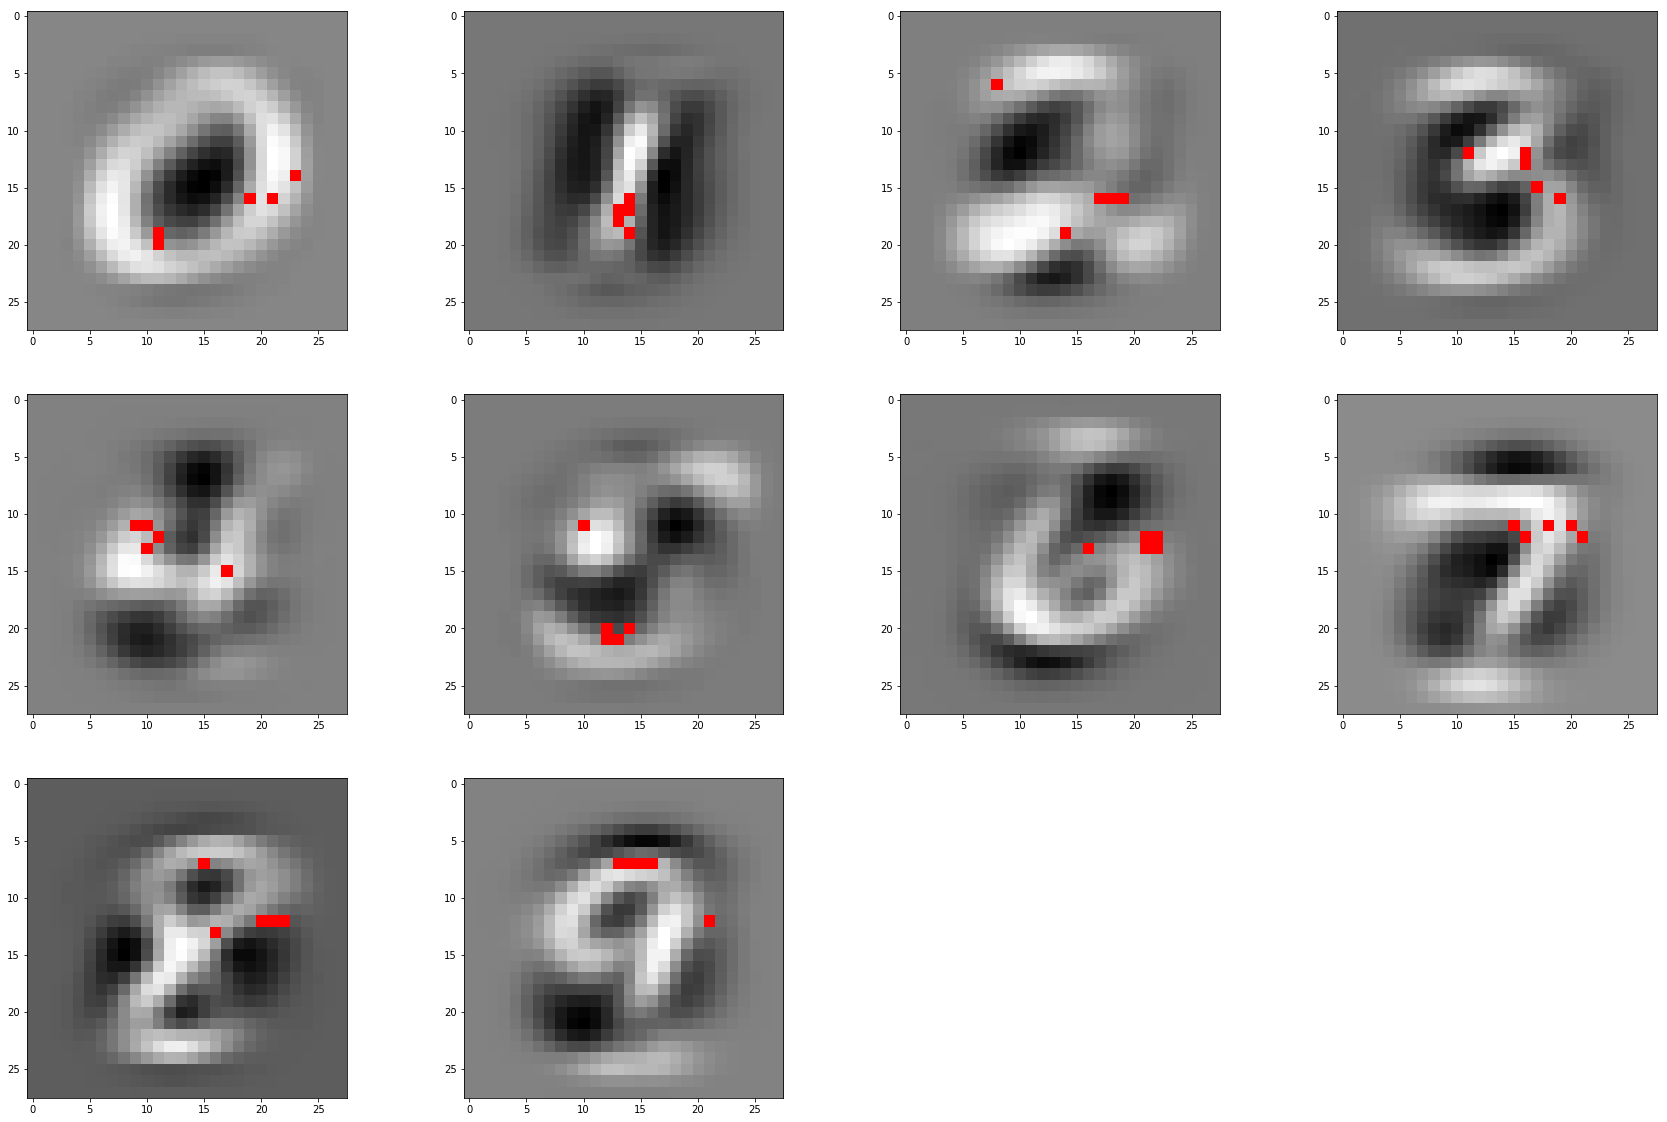

In [649]:
focus(model, 5)

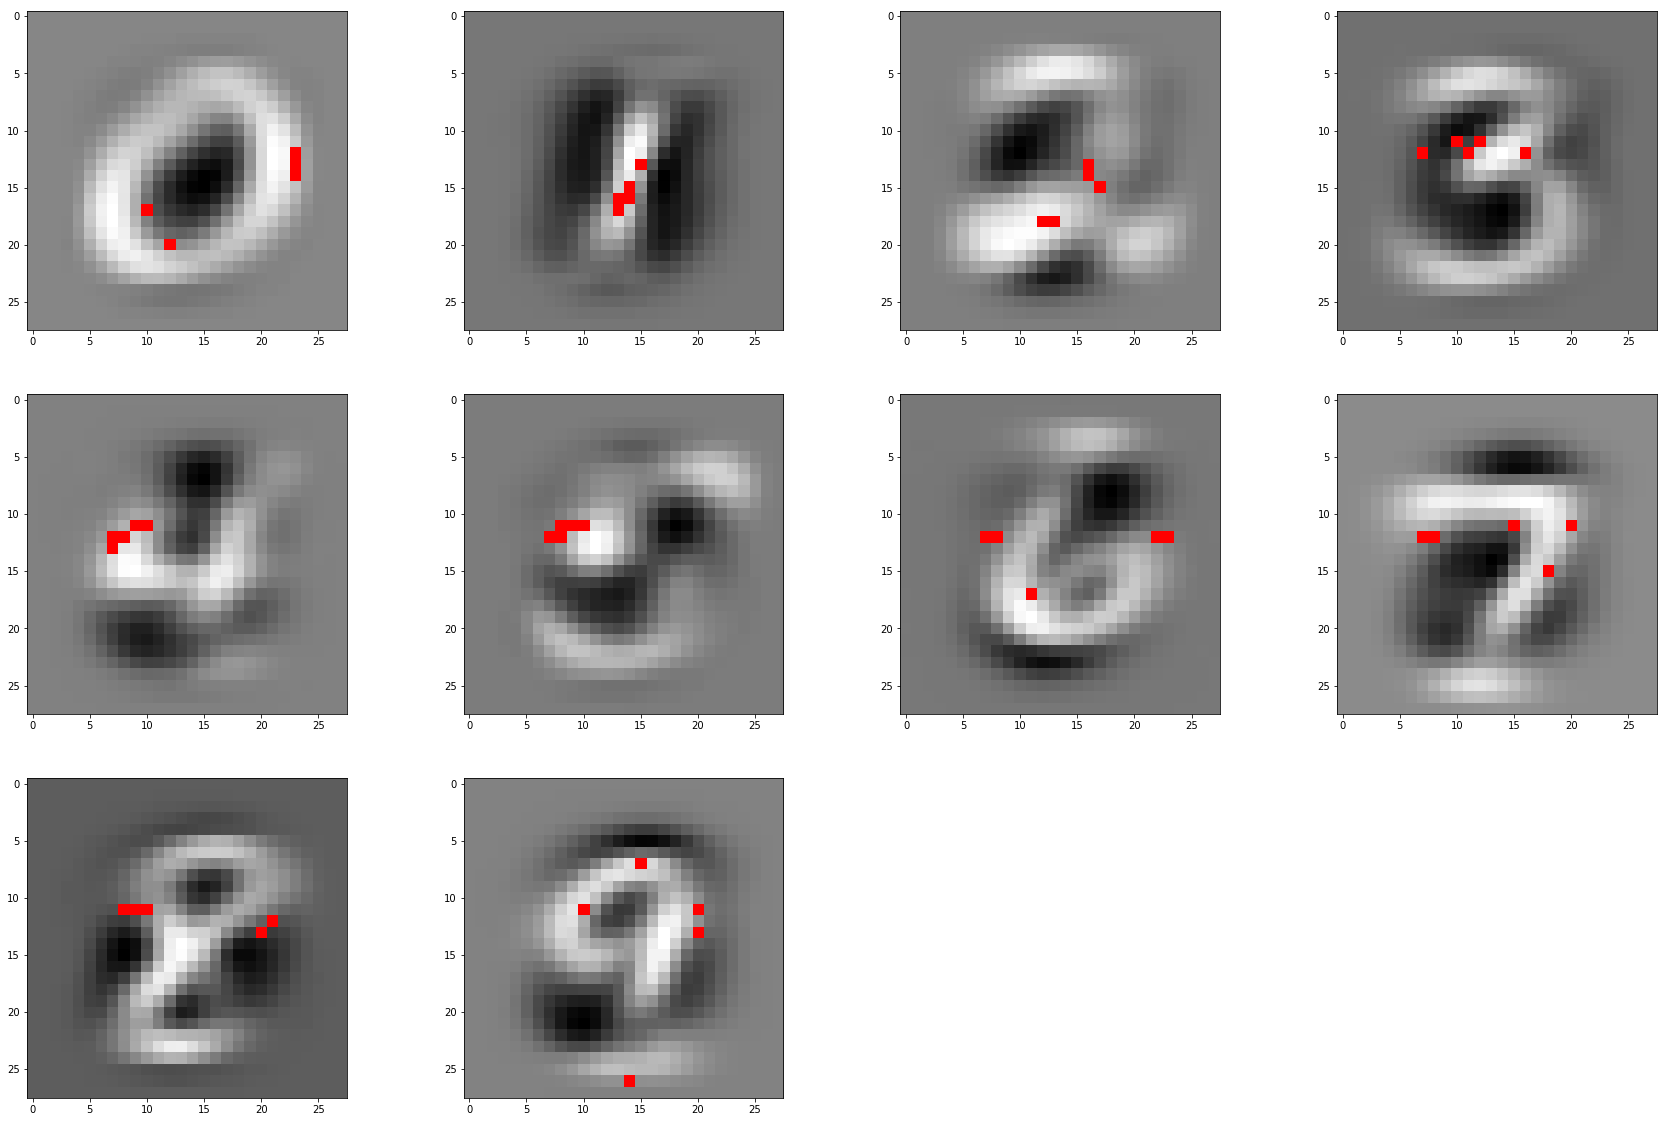

In [651]:
focus(model2, 5)